In [1]:
!pip install transformers
!pip install Sastrawi

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.models import save_model
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
import keras.backend as K

In [3]:
import pandas as pd
import re
import string
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
validation_test = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/manualLabelV1/clean_final_v3.csv')
df = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/trainingEksternalV1/train_clean.csv')

In [46]:
validation_test

,Unnamed: 0,raw,processed,labels
0,0,ganti nomer akun dana no hilang email whatsapp...,ganti nomer akun no hilang email whatsapp tang...,-1
1,1,ketahuan pakai teman pakai dana susah banget t...,ketahuan pakai teman pakai susah banget tarik ...,-1
2,2,aneh verifikasi ktp katanya ktp palsu sim pals...,aneh verifikasi ktp katanya ktp palsu sim pals...,-1
3,3,kirim request proses konfirm masuk pihak dana ...,kirim request proses konfirm masuk pihak saldo...,-1
4,4,pihak ovo jam mengisi pulsa pelanggan masuk ga...,pihak jam mengisi pulsa pelanggan masuk gagal ...,-1
...,...,...,...,...
196,196,kemarin nyaman loading tap kali loading tap ka...,kemarin nyaman loading tap kali loading tap ka...,-1
197,197,kocak gak token vocer diskon topup gak kayak p...,kocak gak token vocer diskon topup gak kayak p...,-1
198,198,menyampaikan pendapat semoga layanan syariah l...,menyampaikan pendapat semoga layanan syariah l...,-1
199,199,download ovo top up coba untuk isi pulsa lakuk...,download top up coba untuk isi pulsa lakukan b...,-1


In [47]:
df['tweet'] = df['processed']
df['tweet']

0       tm tengah struggle financially maxis margin ta...
1       mygoodnes beli kerusiecret lab throne series l...
2       tempat susah ditemukan pelayanan buruk untuk m...
3       tempat strategis lokasi mudah dijangkau salah ...
4       tempat baik untuk merileksasikan pikiran tubuh...
                              ...                        
5533    quran kitab suci abal abal almaidah sumber pem...
5534    dasar fadli zon badan besar kepala besar mulut...
5535    gubernur jakarta penting ahok manusia gede ban...
5536    terima nasabah untuk tahun kebersamaan tahun b...
5537    tengah hadap depre ion libatkan hampa kakak ta...
Name: tweet, Length: 5538, dtype: object

In [48]:
df['labels'].value_counts()

-1    2769
 1    2769
Name: labels, dtype: int64

In [49]:
X = np.array(df['tweet'].tolist())
y = np.array(df['labels'].tolist())

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [50]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4430,)
(4430,)
(1108,)
(1108,)


In [51]:
className = {
    0 : -1,
    1 : 1
}
def oneHotEncode(listArray):
  s = (len(listArray),len(np.unique(listArray)))
  tempData = np.zeros(s)
  for i in range(len(listArray)):
    if listArray[i] == 1:
      tempData[i][1] = 1
    elif listArray[i] == -1:
      tempData[i][0] = 1
  return tempData



In [52]:
y_train = oneHotEncode(y_train)
y_test = oneHotEncode(y_test)

In [53]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### vectorizer

In [54]:
# Setup text vectorization variables
max_vocab_length = 350 # max number of words to have in our vocabulary
max_length = 33
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

Beautiful!

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [55]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X)

contoh

In [56]:
# Create sample sentence and tokenize it
sample_sentence = "fendi kae affan gas ayo"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 33), dtype=int64, numpy=
array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [57]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 350
Top 5 most common words: ['', '[UNK]', 'tempat', 'makanan', 'untuk']
Bottom 5 least common words: ['aneh', 'top', 'stroberi', 'merasa', 'menggunakan']


### Creating an Embedding using an Embedding Layer

> Indented block



We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [58]:
embedding = layers.Embedding(
    input_dim=max_vocab_length, # set input shape
    output_dim=128, # set size of embedding vector
    embeddings_initializer="uniform", # default, intialize randomly
    input_length=max_length
) # how long is each input

embedding

contoh

In [59]:
# Get a random sentence from training set
random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
liburan bandung lembang menyempatkan makan akhir pekan mengantre setimpal rasa makanan harga tempat

Embedded version:


<tf.Tensor: shape=(1, 33, 128), dtype=float32, numpy=
array([[[-9.45650041e-04, -9.41757113e-03, -5.98518923e-03, ...,
          6.38198853e-03,  1.78742521e-02, -2.56370436e-02],
        [ 4.96587195e-02,  3.52759697e-02, -6.71371818e-05, ...,
          3.62263210e-02, -3.90116684e-02,  4.80352975e-02],
        [-3.95645611e-02,  1.36929043e-02,  1.48959495e-02, ...,
         -3.66096571e-03,  2.04069056e-02, -2.32273340e-03],
        ...,
        [-9.22445208e-03,  4.89008762e-02,  4.57606427e-02, ...,
          3.28630209e-03,  1.33618005e-02,  4.28534038e-02],
        [-9.22445208e-03,  4.89008762e-02,  4.57606427e-02, ...,
          3.28630209e-03,  1.33618005e-02,  4.28534038e-02],
        [-9.22445208e-03,  4.89008762e-02,  4.57606427e-02, ...,
          3.28630209e-03,  1.33618005e-02,  4.28534038e-02]]],
      dtype=float32)>

# Model

In [60]:
max_fatures = 2000

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(x_train)

X = tokenizer.texts_to_sequences(x_train)
X = pad_sequences(X)

In [61]:
# MODEL CNN-LSTM
inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x) # return vector for whole sequence

out = tf.keras.layers.Dense(64, activation='relu')(x)
out = tf.keras.layers.Dense(16, activation='relu')(x)

out = tf.keras.layers.Dropout(0.5)(out)

outputs = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="model_LSTM")

In [62]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.TruePositives(name='TruePositive'),
    tf.keras.metrics.FalsePositives(name='FalsePositive'),
    tf.keras.metrics.TrueNegatives(name='TrueNegative'),
    tf.keras.metrics.FalseNegatives(name='FalseNegative'), 
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    get_f1
]

# Compile model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=METRICS,
)

In [63]:
model.summary()

Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 33)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 33, 128)           44800     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 32)            8224      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2

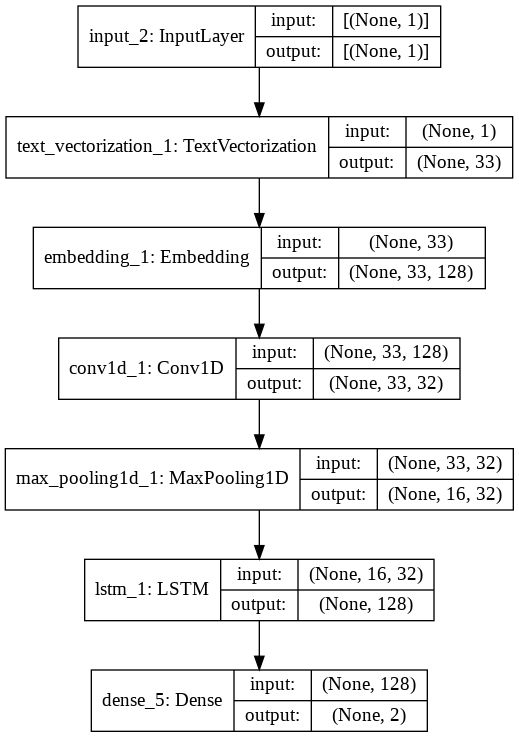

In [64]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-be57d609-7591-6520-5dd7-4e7dc3f393ed)


In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    restore_best_weights=True,
    patience=3, 
    min_delta=0.01, 
    monitor='val_loss'
)

In [67]:
epoch = 20
# Fit model

model_history = model.fit(x_train,
  y_train,
  epochs=epoch,
  batch_size=60,
  validation_data=(x_test, y_test),
  verbose=1,
  callbacks=[early_stopping]
)

Epoch 1/20
74/74 [==============================] - 17s 165ms/step - loss: 0.5156 - TruePositive: 3337.0000 - FalsePositive: 1093.0000 - TrueNegative: 3337.0000 - FalseNegative: 1093.0000 - accuracy: 0.7533 - precision: 0.7533 - recall: 0.7533 - auc: 0.8285 - get_f1: 0.7534 - val_loss: 0.4427 - val_TruePositive: 895.0000 - val_FalsePositive: 213.0000 - val_TrueNegative: 895.0000 - val_FalseNegative: 213.0000 - val_accuracy: 0.8078 - val_precision: 0.8078 - val_recall: 0.8078 - val_auc: 0.8790 - val_get_f1: 0.8102
Epoch 2/20
74/74 [==============================] - 11s 150ms/step - loss: 0.3984 - TruePositive: 3702.0000 - FalsePositive: 728.0000 - TrueNegative: 3702.0000 - FalseNegative: 728.0000 - accuracy: 0.8357 - precision: 0.8357 - recall: 0.8357 - auc: 0.9000 - get_f1: 0.8357 - val_loss: 0.4023 - val_TruePositive: 907.0000 - val_FalsePositive: 201.0000 - val_TrueNegative: 907.0000 - val_FalseNegative: 201.0000 - val_accuracy: 0.8186 - val_precision: 0.8186 - val_recall: 0.8186 - v

In [68]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y= model_history.history["accuracy"], x=model_history.epoch,mode="lines+markers", name="Training accuracy"))
fig.add_trace(go.Scatter(y= model_history.history["val_accuracy"], x=model_history.epoch,mode="lines+markers", name="Val accuracy"))
fig.show()

fig = go.Figure() 
fig.add_trace(go.Scatter(y= model_history.history["loss"], x= model_history.epoch,mode="lines+markers", name="Training loss"))
fig.add_trace(go.Scatter(y= model_history.history["val_loss"], x= model_history.epoch,mode="lines+markers", name="Val loss"))
fig.show()

fig = go.Figure() 
fig.add_trace(go.Scatter(y= model_history.history["get_f1"], x= model_history.epoch,mode="lines+markers", name="F1 Accuracy"))
fig.add_trace(go.Scatter(y= model_history.history["val_get_f1"], x= model_history.epoch,mode="lines+markers", name="Val F1 Accuracy"))
fig.show()

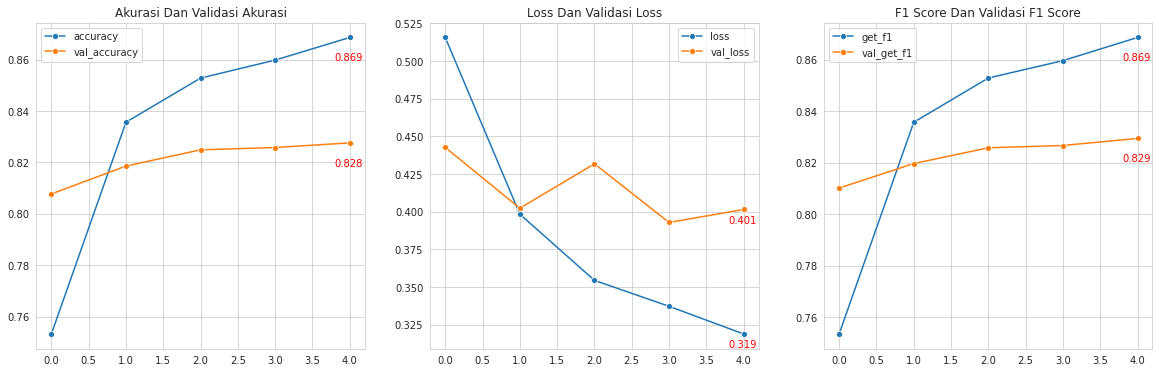

In [80]:
sns.set_style(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(20,6))
graph = ['accuracy', 'loss', 'get_f1']
title = ["Akurasi Dan Validasi Akurasi", "Loss Dan Validasi Loss", "F1 Score Dan Validasi F1 Score"]

def draw_graph(i, text, title):
    axes[i].set_title(title)
    fig = sns.lineplot(ax=axes[i], x=model_history.epoch, y=model_history.history[text], marker='o')
    fig = sns.lineplot(ax=axes[i], x=model_history.epoch, y=model_history.history[f'val_{text}'], marker='o')
    axes[i].legend([text, f'val_{text}'])

def text_graph(i, text):
    for j, (x, y) in enumerate(zip(model_history.epoch, model_history.history[f'{text}'])):
        if j == 4:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 
    
    for j, (x, y) in enumerate(zip(model_history.epoch, model_history.history[f'val_{text}'])):
        if j == 4:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 

for i, (val, tit) in enumerate(zip(graph, title)):
    draw_graph(i, val, tit)
    text_graph(i, val)


In [70]:
validation_test['tweet'] = validation_test['processed']
validation_test['labels'].value_counts()

-1    169
 1     32
Name: labels, dtype: int64

In [71]:
X = np.array(validation_test['tweet'].to_list())
y = oneHotEncode(np.array(validation_test['labels'].tolist()))

In [72]:
model_eval =  model.evaluate(X, y, batch_size=60)

4/4 [==============================] - 0s 16ms/step - loss: 0.4283 - TruePositive: 168.0000 - FalsePositive: 33.0000 - TrueNegative: 168.0000 - FalseNegative: 33.0000 - accuracy: 0.8358 - precision: 0.8358 - recall: 0.8358 - auc: 0.8896 - get_f1: 0.8161


In [73]:
model_eval

[0.42831674218177795,
 168.0,
 33.0,
 168.0,
 33.0,
 0.8358209133148193,
 0.8358209133148193,
 0.8358209133148193,
 0.8895572423934937,
 0.8160713315010071]

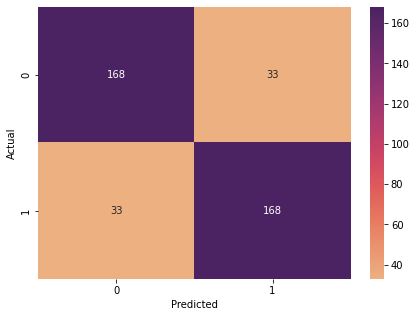

In [74]:
plt.figure(figsize=(7, 5))
sns.heatmap((
    [int(model_eval[1]), int(model_eval[2])],  
    [int(model_eval[2]), int(model_eval[1])]
), annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [75]:
def predictText(text):
    return className[np.argmax(model.predict([text]))]

In [76]:
model.save('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/models/CNN_LSTM')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/DAC UNPAD: Yaudahlah/models/CNN_LSTM/assets


In [77]:
df_predict_dana = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/nonLabelV1/dana.csv')
df_predict_link = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/nonLabelV1/link.csv')
df_predict_ovo = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/nonLabelV1/ovo.csv')
df_predict_sakuku = pd.read_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/nonLabelV1/sakuku.csv')

In [78]:
df_predict = [df_predict_dana,df_predict_link,df_predict_ovo,df_predict_sakuku]
name = ['dana','link','ovo','sakuku']

In [79]:
for k, dataframe in enumerate(df_predict):
    temp = model.predict(dataframe['processed'])
    list = []
    for i in range(len(temp)):
      list.append(className[np.argmax(temp[i])])
    dataframe['predict'] = list
    dataframe.to_csv('/content/drive/Shareddrives/DAC UNPAD: Yaudahlah/data/predictV1/{}.csv'.format(name[k]),index=False)